In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

In [2]:
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['target'] = boston.target

# 前処理: カテゴリ変数化
df.RAD = df.RAD.astype(np.int8)
df.RAD = df.RAD.map(lambda x: chr(x - 1 + ord('A')) )

df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,A,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,B,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,B,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,C,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,C,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,A,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,A,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,A,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,A,273.0,21.0,393.45,6.48,22.0


## パレート図(ヒストグラム+累積相対度数)
階級数は$ 1 + log_2(N)$個で分割すると良い(スタージェスの公式)．

In [3]:
print(df.AGE.min(), df.AGE.max())

binned = pd.cut(df.AGE, [10*x for x in range(11)])
distribution = pd.DataFrame(binned.value_counts().sort_index())
# 階級値
distribution['level'] = distribution.index.map(lambda x: (x.left + x.right)/2)
# 相対度数
distribution['rel_counts'] = distribution['AGE'] / distribution['AGE'].sum()
# 累積相対度数
distribution['acm_rel_counts'] = distribution['rel_counts'].cumsum()
distribution

2.9 100.0


,AGE,level,rel_counts,acm_rel_counts
"(0, 10]",14,5.0,0.027668,0.027668
"(10, 20]",20,15.0,0.039526,0.067194
"(20, 30]",30,25.0,0.059289,0.126482
"(30, 40]",45,35.0,0.088933,0.215415
"(40, 50]",38,45.0,0.075099,0.290514
"(50, 60]",38,55.0,0.075099,0.365613
"(60, 70]",34,65.0,0.067194,0.432806
"(70, 80]",47,75.0,0.092885,0.525692
"(80, 90]",72,85.0,0.142292,0.667984
"(90, 100]",168,95.0,0.332016,1.000000


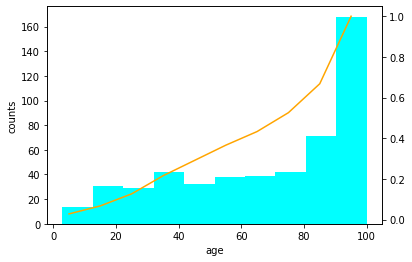

In [4]:
fig, ax1 = plt.subplots()
ax1.hist(df.AGE, label=binned, color='cyan')
ax1.set_xlabel('age')
ax1.set_ylabel('counts')

ax2 = ax1.twinx()
ax2.plot(distribution.level.astype(int), distribution.acm_rel_counts, 
                c='orange')

plt.show()

## ローレンツ曲線
数の偏り具合(e.g. 都道府県ごとのスクリーン数，所得の格差)を表す．  
45度の直線(完全平等線)から右下に偏るほど分布が偏っている．  
所得格差の文脈では，ローレンツ曲線が(.8, .3)を通る場合，2割の人が7割の資産を持つ．

In [36]:
levels = np.array([25,75,125,175,225,275,325,375])
n_screens = np.array([646,918,239,377,641,258,0,358])
counts = np.array([24,14,2,2,3,1,0,1])
df2 = pd.DataFrame.from_dict({'level':levels, 'count':counts,'screen':n_screens})

df2['acc_rel_counts_level'] = (df2['count'] / df2['count'].sum()).cumsum()
df2['acc_rel_screens'] = (df2['screen'] / df2['screen'].sum()).cumsum()
df2

,level,count,screen,acc_rel_counts_level,acc_rel_screens
0,25,24,646,0.510638,0.187955
1,75,14,918,0.808511,0.455048
2,125,2,239,0.851064,0.524585
3,175,2,377,0.893617,0.634274
4,225,3,641,0.957447,0.820774
5,275,1,258,0.978723,0.895839
6,325,0,0,0.978723,0.895839
7,375,1,358,1.000000,1.000000


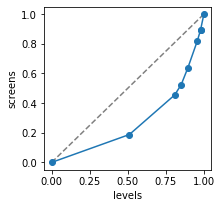

In [38]:
x_counts = np.append(np.array([0]), (df2.acc_rel_counts_level.values))
y_screens = np.append(np.array([0]), (df2.acc_rel_screens.values))

plt.figure(figsize=(3,3))
plt.xlabel('levels')
plt.ylabel('screens')
plt.plot([0,1], [0,1], ls='--',c='gray')
plt.plot(x_counts,y_screens, marker='o')
plt.show()

(levels,screens) = (.8, .5)あたりを通ることから，8割の都道府県によって5割のスクリーンが保有されていることがわかる．

## ジニ係数
ローレンツ曲線を用いて分布の偏りを表す．  
完全平等線とローレンツ曲線を結んだ面積の2倍で求められる．  
$$ {\rm gini} = 2 A(f:y=x, \, g:{\rm Lorenz curve})$$
面積は完全平等線下の面積$-$ローレンツ曲線下の面積で求める(省略)．